<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Machine Learning Pipeline</span></div>

In [11]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN


#from getml.predictors import XGBoostClassifier
#import xgboost as xgb
# SHAP
# interpretability


import shap
#shap.initjs()




In [2]:
#df = pd.read_csv('Empty Notebooks/cc_df.csv', nrows=100000)

df = pd.read_csv('data/g4_filtered.csv', nrows=100000)

df.shape

(10426, 222)

Would Recommend:       0
0  10046
1    380
Proportion Chance Criterion: 92.98%
1.25 * Proportion Chance Criterion: 116.22%


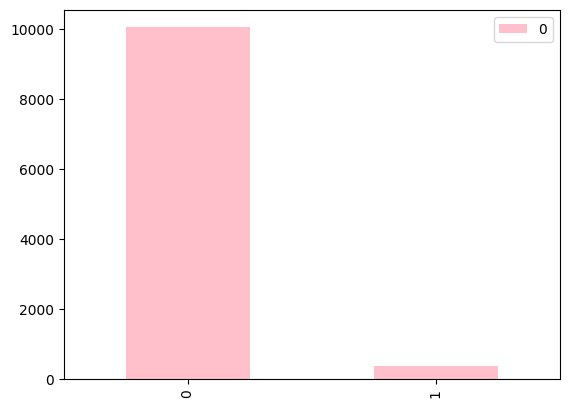

In [3]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [4]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [5]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    #for model_name, model in tqdm(models_dict.items()):
    for model_name, model in models_dict.items():
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline

In [6]:
#models_dict = {'GaussianNB': GaussianNB(),
              #'RandomForestClassifier': RandomForestClassifier(random_state=143)}

    
    
# models_dict = {
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'LogisticRegressor': LogisticRegression(),
#     'GaussianNB': GaussianNB(),
#     'RandomForestClassifier': RandomForestClassifier(random_state=143),
#     'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
#     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)   
# }


models_dict = {
     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143),   
     'RandomForestClassifier': RandomForestClassifier(random_state=143),
     'LogisticRegressor': LogisticRegression(),
 }

In [7]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
GradientBoostingClassifier,99.82%,99.30%,99.74%,93.68%,1.997452
RandomForestClassifier,100.00%,99.27%,100.00%,88.42%,0.674152
LogisticRegressor,98.69%,98.30%,68.16%,60.35%,0.055013


### Applying resampling techniques

#### Oversampling

In [12]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


0it [00:00, ?it/s]

Resampling done in 0.11402559280395508
Resampling done in 0.051010847091674805
Resampling done in 0.037009477615356445
Resampling done in 0.04000997543334961
Resampling done in 0.03600883483886719


0it [00:00, ?it/s]

Resampling done in 0.0400090217590332
Resampling done in 0.03800845146179199
Resampling done in 0.03700828552246094
Resampling done in 0.03500795364379883
Resampling done in 0.036008358001708984


0it [00:00, ?it/s]

Resampling done in 0.041008949279785156
Resampling done in 0.03900909423828125
Resampling done in 0.03600811958312988
Resampling done in 0.033007144927978516
Resampling done in 0.03800797462463379


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
GradientBoostingClassifier,99.82%,99.27%,99.99%,96.49%,6.01936
RandomForestClassifier,100.00%,99.28%,100.00%,90.88%,1.54735
LogisticRegressor,99.36%,98.53%,99.84%,94.04%,0.17504


--------------------------------------------------ADASYN---------------------------------------------------


0it [00:00, ?it/s]

Resampling done in 0.05501246452331543
Resampling done in 0.045011043548583984
Resampling done in 0.05901288986206055
Resampling done in 0.05701279640197754
Resampling done in 0.0580134391784668


0it [00:00, ?it/s]

Resampling done in 0.06201362609863281
Resampling done in 0.05401349067687988
Resampling done in 0.05501222610473633
Resampling done in 0.05601215362548828
Resampling done in 0.07101607322692871


0it [00:00, ?it/s]

Resampling done in 0.06001424789428711
Resampling done in 0.05801248550415039
Resampling done in 0.056012630462646484
Resampling done in 0.05901384353637695
Resampling done in 0.05901217460632324


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
GradientBoostingClassifier,99.80%,99.18%,99.98%,94.74%,6.515473
RandomForestClassifier,100.00%,99.22%,100.00%,90.53%,1.708386
LogisticRegressor,99.35%,98.45%,99.91%,94.04%,0.239056


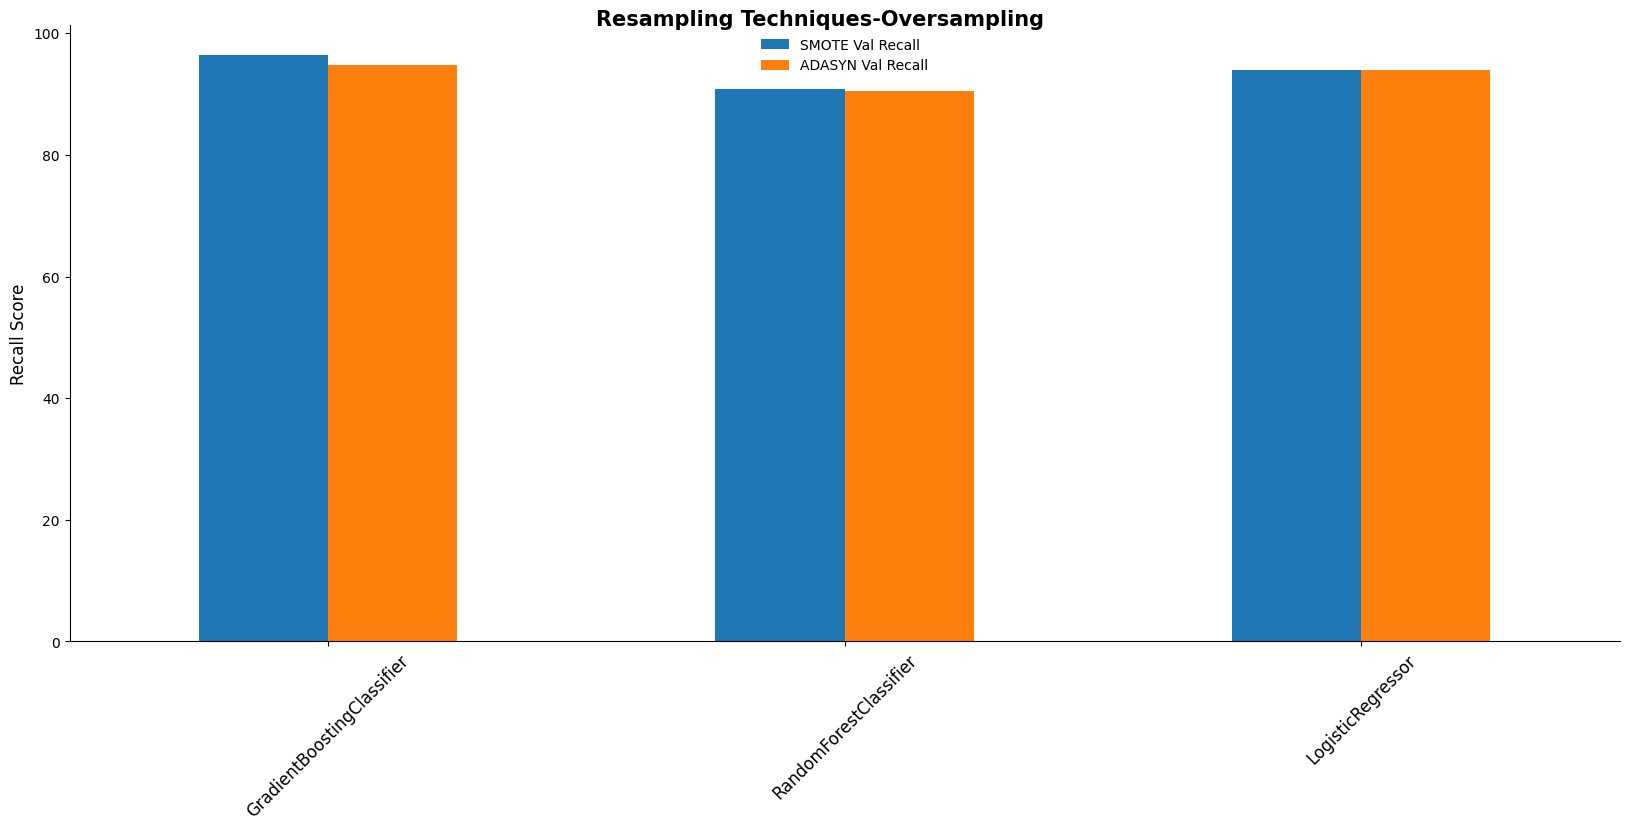

In [13]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [14]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


0it [00:00, ?it/s]

Resampling done in 0.1360301971435547
Resampling done in 0.12102603912353516
Resampling done in 0.12202715873718262
Resampling done in 0.12502789497375488
Resampling done in 0.12502717971801758


0it [00:00, ?it/s]

Resampling done in 0.14603161811828613
Resampling done in 0.13503026962280273
Resampling done in 0.13503026962280273
Resampling done in 0.17003870010375977
Resampling done in 0.13402915000915527


0it [00:00, ?it/s]

Resampling done in 0.1290280818939209
Resampling done in 0.13102936744689941
Resampling done in 0.14603257179260254
Resampling done in 0.1400306224822998
Resampling done in 0.14103150367736816


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
GradientBoostingClassifier,99.81%,99.28%,99.65%,92.98%,2.197497
RandomForestClassifier,100.00%,99.30%,100.00%,89.12%,0.695158
LogisticRegressor,98.71%,98.30%,68.60%,60.35%,0.051012


-------------------------------------------------NearMiss--------------------------------------------------


0it [00:00, ?it/s]

Resampling done in 0.033007144927978516
Resampling done in 0.02600574493408203
Resampling done in 0.023005008697509766
Resampling done in 0.023004531860351562
Resampling done in 0.025005340576171875


0it [00:00, ?it/s]

Resampling done in 0.02600550651550293
Resampling done in 0.02600550651550293
Resampling done in 0.028006315231323242
Resampling done in 0.026005983352661133
Resampling done in 0.026005268096923828


0it [00:00, ?it/s]

Resampling done in 0.026005268096923828
Resampling done in 0.029005765914916992
Resampling done in 0.033007144927978516
Resampling done in 0.026005983352661133
Resampling done in 0.029006004333496094


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
GradientBoostingClassifier,100.00%,97.90%,100.00%,98.25%,0.224051
RandomForestClassifier,100.00%,97.67%,100.00%,97.89%,0.22105
LogisticRegressor,97.81%,93.08%,96.75%,94.04%,0.020006


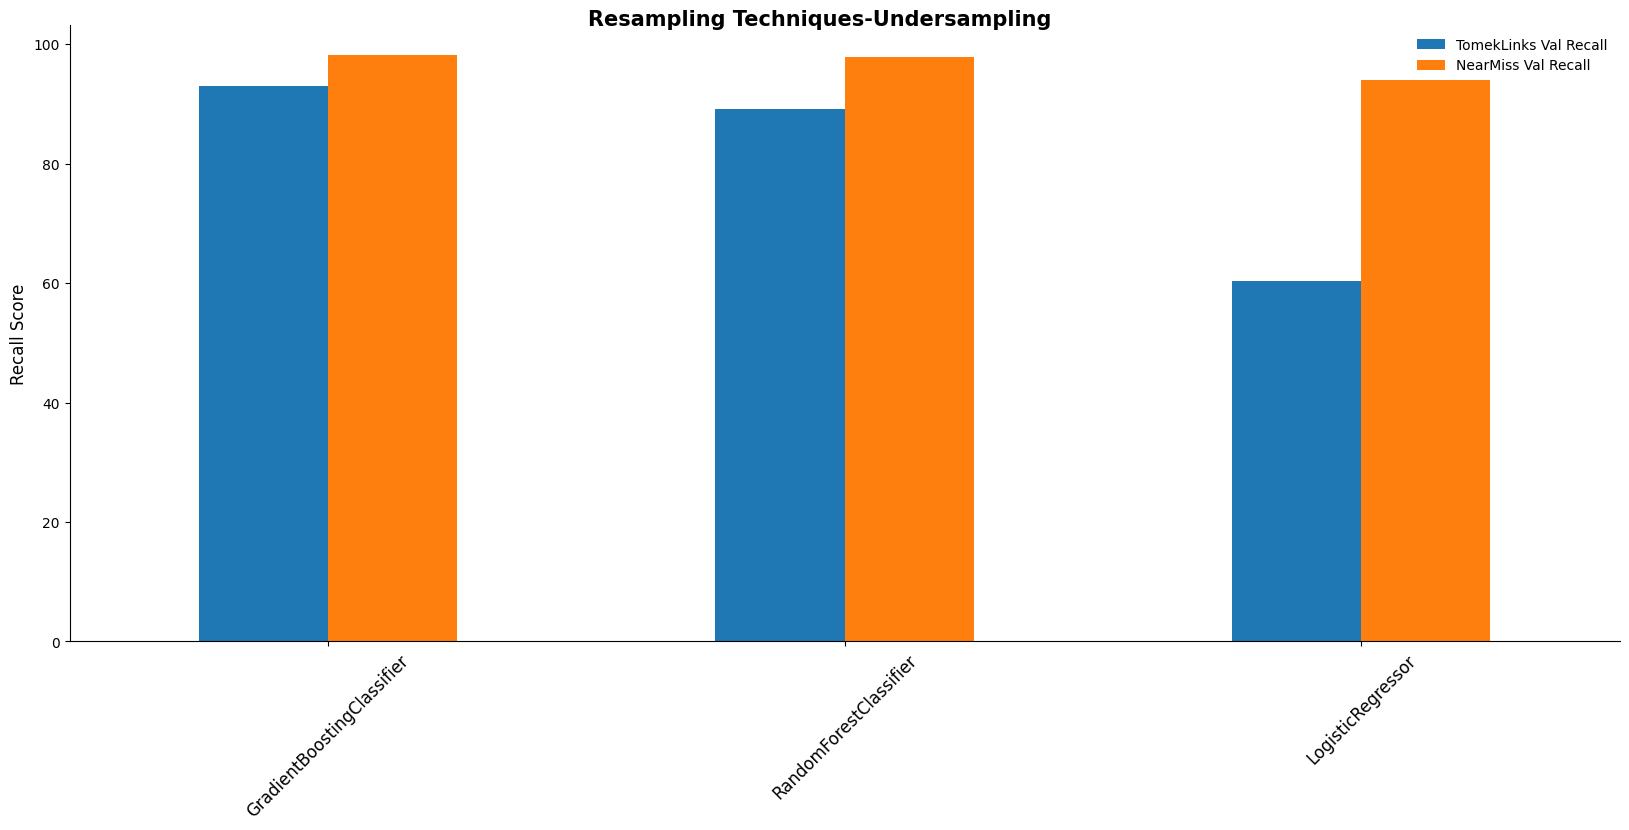

In [15]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [16]:
def train_rf(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune Gradient Boosting Classifier and apply NearMiss()"""
    params = {'n_estimators': [50, 100, 150, 200],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': list(range(3, 20))
              }
    new_params = {'gradientboostingclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      GradientBoostingClassifier())
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      GradientBoostingClassifier())

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10, n_jobs=-1)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['GBC', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['GBC', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [17]:
start_time = time.time()
rf_tmk_rec = train_rf(X_trainval, y_trainval, 'recall', NearMiss(),
                       hypertune=True, resample=True)
start_time = time.time()
rf_tmk_acc = train_rf(X_trainval, y_trainval, 'accuracy', NearMiss(),
                      hypertune=True, resample=True)

Fitting 5 folds for each of 204 candidates, totalling 1020 fits
Fitting 5 folds for each of 204 candidates, totalling 1020 fits


In [18]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [rf_tmk_rec[0],
                np.round(rf_tmk_acc[1]*100, 6),
                np.round(rf_tmk_acc[2]*100, 6),
                np.round(rf_tmk_rec[1]*100, 6),
                np.round(rf_tmk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [rf_tmk_rec[0],
                 '{:.2f}%'.format(np.round(rf_tmk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
GBC,97.29%,97.97%,99.92%,98.60%


In [19]:
rf_tmk_rec

['GBC',
 0.9991529067767458,
 0.9859649122807017,
 "Best parameters = {'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__n_estimators': 200}",
 80.62373685836792,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(max_depth=4, max_features='sqrt',
                                             n_estimators=200))])]

In [20]:
# re-fitting for the holdout
rh = rf_tmk_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

In [21]:
rh_holdout_score

0.9894736842105263

#### Base-case

In [22]:
# cross-validation
base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [23]:
holdout_score

0.9473684210526315

In [24]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,99.74%,93.33%,94.74%
Resampling x Hypertune,99.92%,98.60%,98.95%


In [25]:
import pickle
output = open('pickles/gbc_hypertuned.pkl', 'wb')
pickle.dump(rh, output)
output.close()


# Interpretability

In [26]:
#model = rh
model = rh.fit(X_trainval, y_trainval)

In [27]:
display(len(X_trainval))
model.predict(X_trainval)

7819

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [28]:
y_preds = model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")


Holdout set score: 0.99


In [35]:
# explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)
# shap_values = explainer.shap_values(X_holdout)

In [30]:
#KernelExplainer strongly suggests other measures to minimize computation. One of these is using `K-means` 
# to summarize the background training data instead of using it whole. Another method could be using a sample
# of the training data. In this case, we opted for k-means clustering into 10 centroids.
x_train_summary = shap.kmeans(X_trainval, 10)
#x_train_summary = shap.kmeans(X_holdout, 10)


#KernelExplainer takes a predict function for a model (`fitted_svm_mdl.predict_proba`) and
# some background training data (`X_train_summary`)
explainer = shap.KernelExplainer(model.predict_proba, x_train_summary)

In [31]:
#Once we have initialized our explainer, we can use samples of our test dataset (`nsamples=200`) to come up 
# with the Shapely Values. It uses L1 regularization (`l1_reg`) during the fitting process.  What we are telling 
# it here is to regularize to the point it only has 20 relevant features.

shap_values_test = explainer.shap_values(X_holdout,\
                                nsamples=200, l1_reg="num_features(20)")



  0%|          | 0/2607 [00:00<?, ?it/s]

In [38]:
import pickle

#change explainer to rh/shap values
output = open('data/explainer.pkl', 'wb')
pickle.dump(explainer, output)
output.close()


output = open('data/gbc_hypertuned.pkl', 'wb')
pickle.dump(rh, output)
output.close()


output = open('data/shap_values.pkl', 'wb')
pickle.dump(shap_values_test, output)
output.close()

In [39]:
explainer